In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from functools import partial
from math import log
from typing import Tuple
from pprint import pprint
import matplotlib.pyplot as plt


import gensim
from gensim.models import LsiModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import RegexpTokenizer

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

stemmer = SnowballStemmer("english")

pd.set_option('display.max_columns', 200)

unable to import 'smart_open.gcs', disabling that module


# Read Data and Preprocess

In [2]:
filename = '../2019VAERSData/2019VAERSDATA.csv'

# rawdata = pd.read_csv(filename, header=[0], error_bad_lines=False, encoding="ISO-8859-1")
rawdata = pd.read_csv(filename, header=[0], error_bad_lines=False, encoding="latin-1")

rawdata.columns = rawdata.columns.str.lower()


scrub = ['\x97', '\x96', '\x91', '\x80', '\xad']
for byte in scrub:
    rawdata['symptom_text'] = rawdata['symptom_text'].str.replace(byte, ' ')
    
rawdata['symptom_text'] = rawdata['symptom_text'].str.replace('ç', 'c').fillna('')

dropcols = ['died', 'er_visit', 'hospital', 'disable']


serious_bool = rawdata[dropcols].eq('Y').any(axis=1)
rawdata['serious'] = serious_bool.map({True: 'Y', False: 'N'})


data = rawdata.drop(columns=dropcols)
data = data.set_index('vaers_id')

In [3]:
data.head()

,recvdate,state,age_yrs,cage_yr,cage_mo,sex,rpt_date,symptom_text,datedied,l_threat,hospdays,x_stay,recovd,vax_date,onset_date,numdays,lab_data,v_adminby,v_fundby,other_meds,cur_ill,history,prior_vax,splttype,form_vers,todays_date,birth_defect,ofc_visit,er_ed_visit,allergies,serious
vaers_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
794156,01/01/2019,NaN,69.0,69.0,NaN,F,NaN,"Severe pain Lt. shoulder area, very localized ...",NaN,NaN,NaN,NaN,Y,10/29/2018,10/30/2018,1.0,NaN,PVT,NaN,NaN,none,none,NaN,NaN,2,01/01/2019,NaN,Y,NaN,tetracycline,N
794157,01/01/2019,IL,68.0,68.0,NaN,F,NaN,"Much joint pain/aching, lack of energy, listle...",NaN,NaN,NaN,NaN,N,12/28/2018,12/29/2018,1.0,None,PHM,NaN,"Levothyroxine, sertraline, vitamin B complex, ...",None,Hypothryoidism,Arm soreness at site of injection,NaN,2,01/01/2019,NaN,NaN,NaN,None,N
794158,01/01/2019,MA,62.0,62.0,NaN,F,NaN,"Headache, Fever, Chills, Body Aches, Nausea la...",NaN,NaN,NaN,NaN,Y,12/30/2018,12/31/2018,1.0,NaN,PHM,NaN,"Fish Oil, vitamin D, magnesium.",None,None,NaN,NaN,2,01/01/2019,NaN,NaN,NaN,None,N
794159,01/01/2019,UT,5.0,5.0,NaN,M,NaN,"Site is swollen, red and warm to the touch. Pa...",NaN,NaN,NaN,NaN,Y,12/27/2018,12/28/2018,1.0,None,PVT,NaN,Unknown,Small red spot on his cheek at time of visit.,None,NaN,NaN,2,01/01/2019,NaN,NaN,NaN,Amoxicillin,N
794160,01/01/2019,TX,79.0,79.0,NaN,F,NaN,"FLU LIKE: CHILLS ACHE ALL OVER; STRONG PAIN, W...",NaN,NaN,NaN,NaN,N,12/28/2018,12/28/2018,0.0,NONE TODAY IS A HOLIDAY,PVT,NaN,ATORVASTATIN; CELEBREX; XYZAL; D-3; ELIQUIS; A...,SINUSITIS; ATHROSCLEROSIS; DIABETES; HYPERCHOL...,SAME AS ITEM 11 ABOVE,NaN,NaN,2,01/01/2019,NaN,Y,Y,ACE INHIBITORS,N


# Process Data/Tokenize

In [4]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [5]:
doc_sample = data['symptom_text'].iloc[55]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['I', 'had', 'the', 'FLUZONE', 'shot', 'quad', '2018-19', '.5ml', 'and', 'became', 'sick.', 'First', 'day', 'I', 'was', 'very', 'tired', 'with', 'severe', 'muscle', 'pain', 'and', 'the', 'second', 'day', 'developed', 'harsh', 'voice,', 'sore', 'throat', 'which', 'continued', 'to', 'get', 'worse', 'with', 'chest', 'congestion,', 'coughing', 'and', 'discolored', 'mucous.']


 tokenized and lemmatized document: 
['fluzon', 'shoot', 'quad', 'sick', 'tire', 'sever', 'muscl', 'pain', 'second', 'develop', 'harsh', 'voic', 'sore', 'throat', 'continu', 'wors', 'chest', 'congest', 'cough', 'discolor', 'mucous']


In [6]:
processed_docs = data['symptom_text'].map(preprocess)

In [7]:
processed_docs = list()
for n, doc in enumerate(data['symptom_text']):
    processed_docs.append(preprocess(doc))

In [8]:
dictionary = gensim.corpora.Dictionary(processed_docs)

dictionary.filter_extremes(no_below=15, no_above=0.5)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [9]:
bow_doc_50 = bow_corpus[50]
for i in range(len(bow_doc_50)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_50[i][0], 
                                               dictionary[bow_doc_50[i][0]], 
bow_doc_50[i][1]))

Word 6 ("leav") appears 2 time.
Word 9 ("pain") appears 2 time.
Word 15 ("take") appears 1 time.
Word 22 ("hour") appears 1 time.
Word 39 ("right") appears 1 time.
Word 42 ("shingrix") appears 1 time.
Word 50 ("symptom") appears 1 time.
Word 73 ("dose") appears 1 time.
Word 114 ("receiv") appears 1 time.
Word 140 ("issu") appears 1 time.
Word 176 ("resolv") appears 1 time.
Word 226 ("place") appears 1 time.
Word 255 ("injuri") appears 1 time.
Word 273 ("medic") appears 1 time.
Word 426 ("infect") appears 1 time.
Word 530 ("sharp") appears 1 time.
Word 677 ("eye") appears 1 time.
Word 678 ("stab") appears 1 time.


In [10]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [11]:
# for doc in tfidf[bow_corpus]:
#     print([[dictionary[id], np.around(freq, decimals=2)] for id, freq in doc])

In [12]:
flattened = [{dictionary[tok_id]: np.around(freq, decimals=2) for tok_id, freq in doc} for doc in tfidf[bow_corpus]]

tfidf_df = pd.DataFrame(flattened).fillna(0)

# SVD

In [57]:
tfidf_df.shape

(44344, 3090)

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

clean = [' '.join(toklist) for toklist in processed_docs]

vectorizer = TfidfVectorizer(stop_words='english', 
#                              max_features= 1000, # keep top 1000 terms 
                             max_df = 0.5, 
                             smooth_idf=True)

# X = vectorizer.fit_transform(tfidf_df)
X = vectorizer.fit_transform(clean)


X.shape # check shape of the document-term matrix

(44344, 13943)

In [61]:
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=500, random_state=0)

lsa_fit = svd_model.fit(X)

len(svd_model.components_)

5

In [62]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:5]
    print("Topic "+str(i)+": " + ' + '.join([f'{round(score, 3)}*"{token}"' for token, score in sorted_terms]))
    print()

Topic 0: 0.395*"report" + 0.245*"unknown" + 0.242*"receiv" + 0.223*"medic" + 0.214*"shingrix"

Topic 1: 0.322*"inject" + 0.315*"pain" + 0.295*"site" + 0.234*"swell" + 0.178*"shingrix"

Topic 2: 0.217*"store" + 0.206*"temperatur" + 0.178*"improp" + 0.172*"excurs" + 0.159*"effect"

Topic 3: 0.33*"error" + 0.236*"medic" + 0.177*"holder" + 0.173*"market" + 0.17*"author"

Topic 4: 0.342*"fever" + 0.268*"headach" + 0.255*"chill" + 0.252*"ach" + 0.177*"bodi"



In [63]:
lsa = svd_model.fit_transform(X)

In [64]:
lsa.shape

(44344, 5)

In [72]:
pd.options.display.float_format = '{:,.16f}'.format
topic_encoded_df = pd.DataFrame(lsa)
topic_encoded_df["serious"] = data['serious'].map({'Y': True, 'N': False}).tolist()
topic_encoded_df

,0,1,2,3,4,serious
0,0.0925035923928197,0.1828946713596375,0.0436996435116073,0.0565895118377970,0.0911208245846005,False
1,0.1760624791820814,0.2755701821215781,0.0920659543261978,0.0843333326712484,0.0236866521777341,False
2,0.1228272214355704,0.2628677031626135,0.1461262354222940,0.0701204863231548,0.5893325952981532,False
3,0.1452155427808711,0.3127582223210220,0.1114532397262689,0.1490856140060599,-0.1705233456507348,False
4,0.1303801007342366,0.2847634732194826,0.1078267789429053,0.1160164840837709,0.0731425184061566,False
...,...,...,...,...,...,...
44339,0.0460471650637189,0.0844648540616939,0.0280945842978133,0.0522931427648896,0.0581923696845113,True
44340,0.1203766539286707,0.1235945453683373,0.0532730124528454,0.0727483182293498,-0.0540303217879448,False
44341,0.1005003395626734,0.1460324683577454,0.0616482213143295,0.0565806960611376,0.2863151274241458,False
44342,0.1456512883517405,0.1699560206956388,0.0417926451352442,0.0601793237753495,-0.0442910221661931,False


In [74]:
topic_encoded_df['topic'] = topic_encoded_df[[0, 1, 2, 3, 4]].abs().idxmax(axis=1)

In [76]:
topic_encoded_df

,0,1,2,3,4,serious,topic
0,0.0925035923928197,0.1828946713596375,0.0436996435116073,0.0565895118377970,0.0911208245846005,False,1
1,0.1760624791820814,0.2755701821215781,0.0920659543261978,0.0843333326712484,0.0236866521777341,False,1
2,0.1228272214355704,0.2628677031626135,0.1461262354222940,0.0701204863231548,0.5893325952981532,False,4
3,0.1452155427808711,0.3127582223210220,0.1114532397262689,0.1490856140060599,-0.1705233456507348,False,1
4,0.1303801007342366,0.2847634732194826,0.1078267789429053,0.1160164840837709,0.0731425184061566,False,1
...,...,...,...,...,...,...,...
44339,0.0460471650637189,0.0844648540616939,0.0280945842978133,0.0522931427648896,0.0581923696845113,True,1
44340,0.1203766539286707,0.1235945453683373,0.0532730124528454,0.0727483182293498,-0.0540303217879448,False,1
44341,0.1005003395626734,0.1460324683577454,0.0616482213143295,0.0565806960611376,0.2863151274241458,False,4
44342,0.1456512883517405,0.1699560206956388,0.0417926451352442,0.0601793237753495,-0.0442910221661931,False,1


In [80]:
crosstab = pd.crosstab(topic_encoded_df.topic, topic_encoded_df.serious)
crosstab

serious,False,True
topic,,
0,18650,1549
1,13686,562
2,363,214
3,1881,19
4,6786,634


In [79]:
from scipy import stats

In [81]:
stats.chi2_contingency(crosstab)

(1192.3039088501807,
 7.423020764198414e-257,
 4,
 array([[18842.50031571,  1356.49968429],
        [13291.15027963,   956.84972037],
        [  538.25054122,    38.74945878],
        [ 1772.40212881,   127.59787119],
        [ 6921.69673462,   498.30326538]]))

# Example 2

In [25]:
# from sklearn.feature_extraction.text import CountVectorizer

# # cv = CountVectorizer(ngram_range=(1, 1))
# # X = cv.fit_transform(tfidf_df)

# U, s, Vh = np.linalg.svd(tfidf_df)

In [26]:
# terms = tfidf.columns[:10] #cv.vocabulary_
# for i, component in enumerate(Vh[:10]):
#     terms_components = zip(terms, component)
#     sorted_terms = sorted(terms_components, key=lambda x:x[1], reverse=True)[:10] # take features for topic
#     print("topic : ", i)
#     for term_socres in sorted_terms:
#         print(10*" ", term_socres[0])
#     print(50*'*')

# LSA

In [13]:
# doc_term_matrix = bow_corpus


def compute_coherence_values(dictionary, bow_corpus, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(bow_corpus, num_topics=num_topics, id2word=dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(processed_docs, start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary, bow_corpus, processed_docs,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

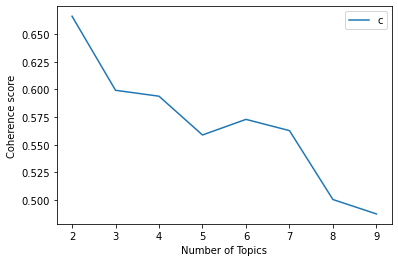

In [14]:
start, stop, step = (2, 10, 1)

plot_graph(processed_docs, start, stop, step)

In [18]:
NUM_TOPICS = 5
# Build the LDA model
lda_model = models.LdaModel(corpus=bow_corpus, num_topics=NUM_TOPICS, id2word=dictionary)
 
# Build the LSI model
lsi_model = models.LsiModel(corpus=bow_corpus, num_topics=NUM_TOPICS, id2word=dictionary)

In [19]:
print("LDA Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 5))
 
print("=" * 20)
 
print("LSI Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lsi_model.print_topic(idx, 5))
 
print("=" * 20)

LDA Model:
Topic #0: 0.073*"report" + 0.040*"dose" + 0.031*"medic" + 0.030*"date" + 0.024*"receiv"
Topic #1: 0.053*"report" + 0.045*"unknown" + 0.041*"receiv" + 0.040*"shingrix" + 0.027*"date"
Topic #2: 0.042*"zoster" + 0.040*"medic" + 0.035*"shingl" + 0.029*"live" + 0.028*"zostavax"
Topic #3: 0.051*"medic" + 0.035*"receiv" + 0.030*"report" + 0.029*"case" + 0.025*"error"
Topic #4: 0.027*"pain" + 0.016*"inject" + 0.016*"swell" + 0.013*"leav" + 0.012*"site"
LSI Model:
Topic #0: 0.471*"report" + 0.337*"receiv" + 0.320*"unknown" + 0.236*"date" + 0.208*"shingrix"
Topic #1: -0.603*"influenza" + -0.304*"virus" + -0.269*"infect" + -0.201*"type" + 0.157*"inject"
Topic #2: 0.405*"inject" + 0.387*"site" + -0.343*"medic" + 0.293*"pain" + 0.250*"shingrix"
Topic #3: 0.473*"site" + 0.461*"inject" + -0.339*"shingrix" + 0.306*"medic" + -0.226*"unknown"
Topic #4: -0.388*"report" + 0.283*"medic" + 0.269*"pain" + 0.170*"zostavax" + 0.163*"shingl"


In [ ]:
lsi_model.

# LDA

In [82]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

Topic: 0 
Words: 0.053*"medic" + 0.039*"receiv" + 0.033*"case" + 0.031*"report" + 0.031*"error"
Topic: 1 
Words: 0.017*"medic" + 0.016*"zoster" + 0.011*"influenza" + 0.011*"shingl" + 0.011*"zostavax"
Topic: 2 
Words: 0.023*"subject" + 0.021*"pregnanc" + 0.019*"mother" + 0.019*"report" + 0.016*"minut"
Topic: 3 
Words: 0.033*"pain" + 0.032*"report" + 0.028*"receiv" + 0.027*"shingrix" + 0.027*"inject"
Topic: 4 
Words: 0.075*"report" + 0.039*"dose" + 0.035*"date" + 0.030*"medic" + 0.030*"unknown"


In [88]:
for idx, topic in lda_model.print_topics(-1, num_words=5):
    print('Topic {}: {}'.format(idx, topic))

Topic 0: 0.053*"medic" + 0.039*"receiv" + 0.033*"case" + 0.031*"report" + 0.031*"error"
Topic 1: 0.017*"medic" + 0.016*"zoster" + 0.011*"influenza" + 0.011*"shingl" + 0.011*"zostavax"
Topic 2: 0.023*"subject" + 0.021*"pregnanc" + 0.019*"mother" + 0.019*"report" + 0.016*"minut"
Topic 3: 0.033*"pain" + 0.032*"report" + 0.028*"receiv" + 0.027*"shingrix" + 0.027*"inject"
Topic 4: 0.075*"report" + 0.039*"dose" + 0.035*"date" + 0.030*"medic" + 0.030*"unknown"


In [87]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=4)

In [89]:
for idx, topic in lda_model_tfidf.print_topics(-1, num_words=5):
    print('Topic {}: {}'.format(idx, topic))

Topic 0: 0.010*"rash" + 0.006*"state" + 0.006*"fever" + 0.006*"shoot" + 0.006*"pain"
Topic 1: 0.022*"ach" + 0.022*"headach" + 0.021*"fever" + 0.020*"chill" + 0.016*"bodi"
Topic 2: 0.021*"swell" + 0.020*"pain" + 0.017*"inject" + 0.016*"site" + 0.016*"red"
Topic 3: 0.032*"shingrix" + 0.019*"unknown" + 0.016*"report" + 0.015*"shingl" + 0.014*"zoster"
Topic 4: 0.020*"medic" + 0.018*"error" + 0.017*"report" + 0.014*"advers" + 0.012*"dose"


In [116]:
# # lda_topics = list()
# lda_tfidf_topics = list()

for doc in bow_corpus:
    topics = lda_model.get_document_topics(doc)
    lda_topics.append(max(topics, key=lambda tup: tup[1])[0])
    
    topics = lda_model_tfidf.get_document_topics(doc)
    lda_tfidf_topics.append(max(topics, key=lambda tup: tup[1])[0])

In [117]:
len(lda_topics)

44344

In [118]:
len(lda_tfidf_topics)

44344

In [125]:
lda_serious = data[['serious']].copy()
lda_serious['serious'] = lda_serious['serious'].map({'Y': True, 'N': False})
lda_serious['topic'] = lda_topics

In [126]:
lda_serious

,serious,topic
vaers_id,,
794156,False,3
794157,False,3
794158,False,3
794159,False,3
794160,False,3
...,...,...
852706,True,3
852710,False,3
852719,False,3


In [127]:
crosstab = pd.crosstab(lda_serious.topic, lda_serious.serious)
crosstab

serious,False,True
topic,,
0,2857,22
1,3117,1893
2,1858,90
3,27376,832
4,6158,141


In [128]:
stats.chi2_contingency(crosstab)

(8736.110115777028,
 0.0,
 4,
 array([[ 2685.65564676,   193.34435324],
        [ 4673.54456071,   336.45543929],
        [ 1817.17860364,   130.82139636],
        [26313.64171027,  1894.35828973],
        [ 5875.97947862,   423.02052138]]))

In [131]:
crosstab[True] / (crosstab[True] + crosstab[False]) * 100

topic
0    0.7641542202153525
1   37.7844311377245532
2    4.6201232032854209
3    2.9495178672716960
4    2.2384505477059853
dtype: float64

In [132]:
lda_serious = data[['serious']].copy()
lda_serious['serious'] = lda_serious['serious'].map({'Y': True, 'N': False})
lda_serious['topic'] = lda_tfidf_topics

In [133]:
crosstab = pd.crosstab(lda_serious.topic, lda_serious.serious)
crosstab

serious,False,True
topic,,
0,8615,1211
1,6357,184
2,10139,406
3,7451,1006
4,8804,171


In [134]:
stats.chi2_contingency(crosstab)

(1484.35956273134,
 0.0,
 4,
 array([[9166.11753563,  659.88246437],
        [6101.72753924,  439.27246076],
        [9836.8318149 ,  708.1681851 ],
        [7889.05515966,  567.94484034],
        [8372.26795057,  602.73204943]]))

In [135]:
crosstab[True] / (crosstab[True] + crosstab[False]) * 100

topic
0   12.3244453490738852
1    2.8130255312643326
2    3.8501659554291132
3   11.8954712072839079
4    1.9052924791086352
dtype: float64

In [137]:
crosstab[True].sum() / (crosstab[True].sum() + crosstab[False].sum()) * 100

6.715677430994046

In [81]:
stats.chi2_contingency(crosstab)

(1192.3039088501807,
 7.423020764198414e-257,
 4,
 array([[18842.50031571,  1356.49968429],
        [13291.15027963,   956.84972037],
        [  538.25054122,    38.74945878],
        [ 1772.40212881,   127.59787119],
        [ 6921.69673462,   498.30326538]]))

In [123]:
lda_serious

,serious,topic
vaers_id,,
794156,N,3
794157,N,3
794158,N,3
794159,N,3
794160,N,3
...,...,...
852706,Y,3
852710,N,3
852719,N,3


In [112]:
max(a, key=lambda tup: tup[1])[0]

3

In [ ]:
max

In [107]:
lda_model.get_document_topics(bow_corpus[555])

[(0, 0.025375519),
 (1, 0.026072707),
 (2, 0.025612371),
 (3, 0.89705414),
 (4, 0.025885278)]

In [100]:
topics.chunksize

In [102]:
topics.obj.g

In [11]:
# add columns age/sex/curr ill/num days to clustering
clusters = 5
model = KMeans(n_clusters=clusters, init='k-means++', max_iter=100, n_init=1)
model.fit(merged)

# tfidf['cluster'] = model.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=5, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [30]:
for cluster_index in range(clusters):
    cluster = merged[(model.labels_ == cluster_index)]
#     cluster = tfidf[tfidf.cluster.eq(cluster_index)]

    tfidf = cluster[:, 5:]
    tfidf_mean = tfidf.mean(axis=0)
    tfidf_mean = np.squeeze(np.asarray(tfidf_mean))
    
    ave_age = cluster[:, 0].mean()
    male = 
    
    top_ten = tfidf_mean.argsort()[-10:][::-1]
    
    print(f"Cluster {cluster_index} (size={len(cluster)}):")
    print("-----------------------------------------")
    print(', '.join(ind_to_token[idx] for idx in top_ten))
    print()

Cluster 0 (size=14944):
-----------------------------------------
patienr, unknowingly, reportable, datasheet, receive, dosde, vaccince, medicaitons, shingritz, cascading

Cluster 1 (size=6794):
-----------------------------------------
vaccince, patienr, fetzima, givein, rarity, dawned, swellin, rednes, reactio, sitagliptin

Cluster 2 (size=6855):
-----------------------------------------
arlv, patienr, pail, injectio, dawned, sitagliptin, shingritz, swellin, rednes, rarity

Cluster 3 (size=11178):
-----------------------------------------
pail, arlv, injectio, patienr, dawned, fetzima, sitagliptin, headach, chileed, shingritz

Cluster 4 (size=4573):
-----------------------------------------
patienr, vaccince, arlv, pail, givein, injectio, sitagliptin, dawned, psychotropics, lefse



In [ ]:
cluster[:, 0].mean()

In [31]:
cluster[:, 0].mean()

21.287338727312488

In [26]:
merged[:, 0].mean()

45.967172807380685

In [28]:
cluster

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

distance measure:  

https://scikit-learn.org/stable/modules/clustering.html#k-means  
within-cluster sum-of-squares

In [314]:
data.shape

(44344, 31)

In [315]:
data['cluster'] = model.labels_

In [316]:
data.head()

,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DATEDIED,L_THREAT,HOSPDAYS,X_STAY,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,SERIOUS,cluster
VAERS_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
794156,01/01/2019,NaN,69.0,69.0,NaN,F,NaN,"Severe pain Lt. shoulder area, very localized ...",NaN,NaN,NaN,NaN,Y,10/29/2018,10/30/2018,1.0,NaN,PVT,NaN,NaN,none,none,NaN,NaN,2,01/01/2019,NaN,Y,NaN,tetracycline,N,2
794157,01/01/2019,IL,68.0,68.0,NaN,F,NaN,"Much joint pain/aching, lack of energy, listle...",NaN,NaN,NaN,NaN,N,12/28/2018,12/29/2018,1.0,None,PHM,NaN,"Levothyroxine, sertraline, vitamin B complex, ...",None,Hypothryoidism,Arm soreness at site of injection,NaN,2,01/01/2019,NaN,NaN,NaN,None,N,1
794158,01/01/2019,MA,62.0,62.0,NaN,F,NaN,"Headache, Fever, Chills, Body Aches, Nausea la...",NaN,NaN,NaN,NaN,Y,12/30/2018,12/31/2018,1.0,NaN,PHM,NaN,"Fish Oil, vitamin D, magnesium.",None,None,NaN,NaN,2,01/01/2019,NaN,NaN,NaN,None,N,2
794159,01/01/2019,UT,5.0,5.0,NaN,M,NaN,"Site is swollen, red and warm to the touch. Pa...",NaN,NaN,NaN,NaN,Y,12/27/2018,12/28/2018,1.0,None,PVT,NaN,Unknown,Small red spot on his cheek at time of visit.,None,NaN,NaN,2,01/01/2019,NaN,NaN,NaN,Amoxicillin,N,1
794160,01/01/2019,TX,79.0,79.0,NaN,F,NaN,"FLU LIKE: CHILLS ACHE ALL OVER; STRONG PAIN, W...",NaN,NaN,NaN,NaN,N,12/28/2018,12/28/2018,0.0,NONE TODAY IS A HOLIDAY,PVT,NaN,ATORVASTATIN; CELEBREX; XYZAL; D-3; ELIQUIS; A...,SINUSITIS; ATHROSCLEROSIS; DIABETES; HYPERCHOL...,SAME AS ITEM 11 ABOVE,NaN,NaN,2,01/01/2019,NaN,Y,Y,ACE INHIBITORS,N,1


In [318]:
pd.crosstab(data.cluster, data.SERIOUS)

SERIOUS,N,Y
cluster,,
0,5615,127
1,5180,70
2,23078,2002
3,2692,694
4,4801,85


In [317]:
data.pivot_table(index='cluster', columns='SERIOUS')

AGE_YRS              CAGE_MO              CAGE_YR             \
SERIOUS          N          Y         N         Y          N          Y   
cluster                                                                   
0        20.800842  29.995897  0.329412  0.125000  20.980066  34.583333   
1        53.331225  42.505156  0.338415  0.350000  53.379281  43.727273   
2        45.248608  37.005634  0.320905  0.327778  45.369581  36.641509   
3        35.641392  66.529412  0.381116       NaN  34.528746  62.333333   
4        65.462022  64.638158  0.360000       NaN  65.900091  68.027027   

        FORM_VERS             HOSPDAYS    NUMDAYS              
SERIOUS         N         Y          Y          N           Y  
cluster                                                        
0        1.914337  1.960630  11.714286  43.760192  259.485714  
1        1.971622  1.642857   2.437500   8.633550   45.477612  
2        1.961478  1.864136   6.200739  21.420956   28.888430  
3        2.000000  2.000000   3.666667  70.727273  197.685185  
4        1.999792  2.000000   7.115385  12.600000    7.225806

In [269]:
vectorizer.vocabulary_['patient']

20332

In [276]:
tfidf.shape

(44344, 30822)

In [288]:
(model.labels_ == 3).argwhere(True)

AttributeError: 'numpy.ndarray' object has no attribute 'argwhere'

In [305]:
np.argwhere((model.labels_ == 1))

array([[    1],
       [    3],
       [    4],
       ...,
       [44316],
       [44325],
       [44329]])

In [311]:
rawdata.loc[44329].SYMPTOM_TEXT

'Redness and swelling at injection site - 3x2 inch area'

In [275]:
tfidf.mean(axis=0)

KeyboardInterrupt: 

In [218]:
tfidf_mean.shape

(30822,)

In [220]:
tfidf_mean.max()

0.252844294441899

In [221]:
tfidf_mean.argmax()

24680

In [222]:
tfidf_mean.argsort()[-10:][::-1]

array([24680, 20332, 28000, 20084, 22913, 23349, 10801, 23346, 12905,
        9118])

In [231]:
ind_to_word[9118]

'case'

In [211]:
c = cluster[:, 3635]

In [212]:
c.max()

0.0

In [213]:
c.min()

0.0

In [210]:
cluster.shape

(4406, 30822)

In [214]:
cluster

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.16143788, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [173]:
cluster[983]

<1x30822 sparse matrix of type '<class 'numpy.float64'>'
	with 163 stored elements in Compressed Sparse Row format>

In [139]:
sum([1 for text in rawdata['SYMPTOM_TEXT'].fillna('') if '2019434226' in text])

1

In [107]:
sum((model.labels_ == 8))

7089

In [46]:
data.loc[data.SERIOUS.eq('Y'), ['NUM_DAYS', 'SYMPTOM_TEXT', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'BIRTH_DEFECT', 'SERIOUS']].head(16)

,NUM_DAYS,SYMPTOM_TEXT,CUR_ILL,HISTORY,PRIOR_VAX,BIRTH_DEFECT,SERIOUS
VAERS_ID,,,,,,,
794190,NaN,Information has been received on 19-DEC-2018 r...,NaN,NaN,NaN,NaN,Y
794191,NaN,Information has been received on 19-DEC-2018 r...,NaN,NaN,NaN,NaN,Y
794195,NaN,"This is a literature case, initially received ...",NaN,Medical History/Concurrent Conditions: Asthma,NaN,NaN,Y
794197,NaN,As soon as I got the shots and was going to pu...,NaN,Back and neck pain Depression High blood pres...,NaN,NaN,Y
794210,NaN,"Tdap shot, tar stool, cramps in stomach, letha...",NaN,NaN,NaN,NaN,Y
794217,NaN,Vomiting started the day after the vaccine. Pa...,none,none,NaN,NaN,Y
794268,NaN,"Simple Febrile Seizure at home, lasting no mor...",None,Macrocrania- monitoring,NaN,NaN,Y
794271,NaN,Pt is complaining of left upper arm pain/shoul...,none listed,thyroid,NaN,NaN,Y
794291,NaN,Information has been received from a lawyer re...,NaN,NaN,NaN,NaN,Y


In [20]:
serious_bool.map({True: 'Y', False: 'N'})

0        N
1        N
2        N
3        N
4        N
        ..
44339    Y
44340    N
44341    N
44342    N
44343    N
Length: 44344, dtype: object